## Announcements

Finally back after a long hiatus. I took a break from posting and FASTAI to try Advent of Code and get back to interview prep but I’m back. Normally I only write a single summary for a blog post but this time I'm writing two summaries because Chapter 4 of the book goes deeper into the foundations of neural networks than the lecture video.

## Acknowledgements

All of this code was written by Jeremy Howard and the authors of the FastAI book. My modification to their code was adding print statements and comments to understand what each line of code was doing.

## Summary - FastAI Lesson 3 Video

In this lesson, Jeremy gives a high level overview of pytorch, gradient descent and the evolution of models. Most of the video focuses on approximating a quadratic equation and building the intuition towards how a neural network works. Towards the end of the video, Jeremy introduces the Titanic dataset and how to do some basic modeling with excel.

## Summary FastAI Chapter 4

In Chapter 4, the FastAI book authors use the MNIST dataset as a case study to understand how pytorch and the fastai library work under the hood. I found this chapter to be a mind bender because I struggled to wrap my head around the concept of a tensor and the kinds of operations you can do on a tensor. Another concept I struggled with was the meaning of rank and dimension of tensors which are not the same as the meaning of rank and dimension in linear algebra and physics (will go more into this later). By the end of this chapter, I understood the following concepts:

- what a tensor represents and performing operations on a tensor
- how to set up a classifier using pytorch
- how a training loop, optimizer, batch work in pytorch and fastai
- the operations and functions that fastai provides a wrapper on top of

I do agree with Jeremy that this book chapter might scare people away because the jargon combined with the mathematical concepts but its definitely worth spending a few days getting through since you develop a deeper understanding of pytorch and the deep learning process.

## Jeremy Howard's Advice

Jeremy provides some really good insights and advice in the lecture video not captured in the book or kaggle notebooks. This is my summary of the advice:

- Model: Mathematical function consisting of a Matrix Multiply operation + nonlinearity (RELU, Sigmoid etc)

- Things to thing about when picking a class of model for a problem we're trying to solve:
  1. How fast is the model
  2. How much memory does it consume
  3. How accurate is it

- Models fit functions to data and try to recognize patterns in data that we give it

In [1]:
# load libraries and imports
!pip install -Uqq fastai duckduckgo_search
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from PIL import Image
from functools import partial

# import fastai libraries
from fastai.vision.all import *

# update grayscale colormap for matplotlib
matplotlib.rc('image', cmap='Greys')

## MNIST Dataset

To show how neural networks work, the FastAI authors use the MNIST dataset as a case study. MNIST is a dataset containing handwritten digits collected by NIST (National Institute of Standards and Technology) and turned into dataset by Yann Lecun and his colleagues. For more information about Lecun and MNIST I would recommend reading the book chapter.

The MNIST dataset follows traditional machine learning dataset layouts: Training Data and Validation Data each containing images associated with a particular digit between 0-9.

In [41]:
# LOAD MNIST DATA
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
print(f"Contents of MNIST DATA: {path.ls()}")

# MNIST Training Data
print(f"MNIST Training Data Directory Contents: {(path/'train').ls()}")

# MNIST Training Data for 3s and 7s in sorted order
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
# print(f"Sorted Training Data for 3: {threes}")

# Training Data Example
im3_path = threes[1]
im3 = Image.open(im3_path)
print(f"Test Image of 3 from 3 training data set")
im3


Contents of MNIST DATA: [Path('train'), Path('valid'), Path('labels.csv')]
MNIST Training Data Directory Contents: [Path('train/7'), Path('train/3')]
Test Image of 3 from 3 training data set


## Representing Images as Numbers

Images are represented on computers as an array of pixels where each index contains a list of 3 numbers between 0-255 corresponding to a particular color according to RGB. Assembling all of these colors together we get an image.

The MNIST images are represented differently: each index in the image array contains a number between 0-255 where 0 represents white and 255 black. All other values between 0-255 represent a different shade of gray. A unique digit image in the MNIST data is then defined by the black and gray pixels that together outline and define the digit. The size of an image in the MNIST data is 28 x 28 which is 784 pixels in the Image Array.

In the following examples, [4:10, 4:10] means the following: request rows from index 4 (included) to 10(not included) and the same for the columns. Numpy and Pytorch index from top to bottom and left to right.

In the  image slice below, we select a part of the digit with just the top part and then color code the slice based on the values in the slice with their mapping in the gray scale (0-255) where 0 represents white and 255 black.


In [3]:
# MNIST image dimensions are 28 x 28 = 784 pixel array
print(f"im3 represented as an array of numbers using numpy array")
array(im3)

im3 represented as an array of numbers using numpy array


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254,
        255, 254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [4]:
# Slice of im3
# [4:10, 4:10] - get rows and columns starting from 4(included) to 10 (excluded)
# Numpy Array representation
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [5]:
# MNIST image dimensions are 28 x 28 = 784 pixel array
print(f"im3 represented as an array of numbers using tensors")
tensor(im3)

im3 represented as an array of numbers using tensors


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29, 150, 195, 254, 255,
         254, 176, 193, 150,  96,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  4

In [6]:
# Slice of im3
# [4:10, 4:10] - get rows and columns starting from 4(included) to 10 (excluded)
# Tensor representation
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [7]:
# slice data to obtain the top part of the number and color code data to show digit outline
# slice data rows: 4(included)-15(excluded)
# slice data columns: 4(included)-22(excluded)
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## Baseline Model: Pixel Similarity

The problem we're trying to solve is the following: How do we write a computer program to be able to distinguish between images of handwritten 3 and 7 digits.

The first approach we try is **Pixel Similarity**. The FASTAI book authors define this as the following:

1. Take the average pixel value for every pixel of the 3 images and do the same for the 7 images. These averages will produce a baseline image 3 and image 7.
2. Go through every image in the 3 and 7 images and compare them to the baseline images to see which digit they are most similar to

Number of images in threes: 6131
Number of images in three tensors: 6131
Number of images in sevens: 6265
Number of images in seven tensors: 6265


<Axes: >

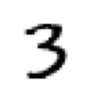

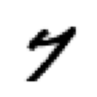

In [8]:
# Create a list of tensors for each image in 3 and 7 directories
three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

print(f"Number of images in threes: {len(threes)}")
print(f"Number of images in three tensors: {len(three_tensors)}")
print(f"Number of images in sevens: {len(sevens)}")
print(f"Number of images in seven tensors: {len(seven_tensors)}")

# verify images
show_image(three_tensors[1])
show_image(seven_tensors[1])

The way I understand tensors is that they are data structures for storing information. The way I understand the stack operation is storing all the images into a pile of images that we then then can average all the pixel values for each pixel index in the image.

In [9]:
# Compute the average intensity of each pixel across all images for 3 and 7
stacked_sevens = torch.stack(seven_tensors).float() / 255
stacked_threes = torch.stack(three_tensors).float() / 255

print(f"stacked_sevens shape: {stacked_sevens.shape}")
print(f"stacked_sevens tensor rank: {len(stacked_sevens.shape)}")
print(f"stacked_threes shape: {stacked_threes.shape}")
print(f"stacked_threes tensor rank: {len(stacked_threes.shape)}")

stacked_sevens shape: torch.Size([6265, 28, 28])
stacked_sevens tensor rank: 3
stacked_threes shape: torch.Size([6131, 28, 28])
stacked_threes tensor rank: 3


In this step, we take the list of tensor images and condense them down into a new image where each pixel index in this new image is the average of all the values at a particular index.

mean3 shape: torch.Size([28, 28])
mean3 tensor rank: 2
mean7 shape: torch.Size([28, 28])
mean7 tensor rank: 2


<Axes: >

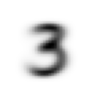

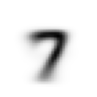

In [10]:
 # Average of all image tensors by taking mean along the 0 dimension (collapse all the rows into a single row) of stacked 3 rank tensors
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)
print(f"mean3 shape: {mean3.shape}")
print(f"mean3 tensor rank: {len(mean3.shape)}")
print(f"mean7 shape: {mean7.shape}")
print(f"mean7 tensor rank: {len(mean7.shape)}")
show_image(mean3)
show_image(mean7)

## Measuring Distance

To compare the baseline image with a randomly chosen image from one of the datasets we need to measure the difference between pixels such that we have a standardized form so that the differences accurately reflect what pixels are dark and light when comparing the two images.

In [11]:
# Mean Absolute Difference (L1 Norm)
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_7 - mean7).abs().mean()

print(f"Mean Absolute Difference between 3 image and ideal 3 image: {dist_3_abs}")
print(f"Mean Absolute Difference between 7 image and ideal 7 image: {dist_7_abs}")

# see how close 3 is to ideal 7
dist_test_abs = (a_3 - mean7).abs().mean()
print(f"Mean Absolute Difference between 3 image and ideal 7 image: {dist_test_abs}")

Mean Absolute Difference between 3 image and ideal 3 image: 0.11143654584884644
Mean Absolute Difference between 7 image and ideal 7 image: 0.13037648797035217
Mean Absolute Difference between 3 image and ideal 7 image: 0.15861910581588745


In [12]:
# Root Mean Squared Error (L2 Norm)
a_3 = stacked_threes[1]
a_7 = stacked_sevens[1]

dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()
dist_test_sqr = ((a_3 - mean7)**2).mean().sqrt()
print(f"Root Mean Squared Difference between 3 image and ideal 3 image: {dist_3_sqr}")
print(f"Root Mean Squared Difference between 7 image and ideal 7 image: {dist_7_sqr}")

# see how close 3 is to ideal 7
print(f"Root Mean Squared Difference between 3 image and ideal 7 image: {dist_test_sqr}")

Root Mean Squared Difference between 3 image and ideal 3 image: 0.20208320021629333
Root Mean Squared Difference between 7 image and ideal 7 image: 0.2584923207759857
Root Mean Squared Difference between 3 image and ideal 7 image: 0.30210891366004944


In [13]:
# Pytorch Mean Squared Error and Mean Absolute Value Loss
print(f"Pytorch Mean Absolute Value Loss between 3 image and ideal 7 image: {F.l1_loss(a_3.float(), mean7)}")
print(f"Pytorch Mean Squared Error Loss between 3 image and ideal 7 image: {F.mse_loss(a_3, mean7).sqrt()}")

Pytorch Mean Absolute Value Loss between 3 image and ideal 7 image: 0.15861910581588745
Pytorch Mean Squared Error Loss between 3 image and ideal 7 image: 0.30210891366004944


## Pytorch + Numpy

The main difference between pytorch and numpy is that pytorch supports using the GPU and calculating gradients which numpy does not.

In [14]:
data = [[1, 2, 3], [4, 5, 6]]
# numpy array
arr = array(data)
# tensor
tns = tensor(data)

# select a row
print(f"select the second row of tensor: {tns[1]}")

# select a column
print(f"select the second column of tensor: {tns[:1]}")

# slicing
print(f"select slice of tensor: {tns[1, 1:3]}")

# addition
print(f"Addition with tensors: {tns + 1}")

# types
print(f"tensor type: {tns.type()}")

# scale and update tensor type
print(f"changing tensor type from int to float: {tns * 1.5}")

select the second row of tensor: tensor([4, 5, 6])
select the second column of tensor: tensor([[1, 2, 3]])
select slice of tensor: tensor([5, 6])
Addition with tensors: tensor([[2, 3, 4],
        [5, 6, 7]])
tensor type: torch.LongTensor
changing tensor type from int to float: tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])


## Computing Metrics

A metric is a number that is calculated based on the predictions of the model and the correct labels and inform us how good the model is. For classification models, **accuracy** is a popular metric.

In [15]:
# create validation data set
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float() / 255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float() / 255

print(f"3 validation set shape: {valid_3_tens.shape}")
print(f"3 validation set tensor rank: {len(valid_3_tens.shape)}")
print(f"7 validation set shape: {valid_7_tens.shape}")
print(f"7 validation set tensor rank: {len(valid_7_tens.shape)}")

3 validation set shape: torch.Size([1010, 28, 28])
3 validation set tensor rank: 3
7 validation set shape: torch.Size([1028, 28, 28])
7 validation set tensor rank: 3


In [16]:
# MNIST Data Distance Function
def mnist_distance(a, b):
  # (-1, -2) represent a range of axes. Tell Pytorch to take the mean ranging over the values
  # indexed by the last two axes of the tensor (horizontal and vertical dimensions of the image)
  # leaves only the first tensor axis which indexes over images and the final size -> averaged the intensity of all the pixels
  # in the image
  return (a - b).abs().mean((-1,-2))
print(f"Distance function measuring the distance between 3 image and ideal 3 image: {mnist_distance(a_3, mean3)}")

# measure distance between validation set 3 and ideal 3 tensor
valid_3_dist = mnist_distance(valid_3_tens, mean3)
print(f"Distance between validation set 3 image and ideal training data set 3 image: {valid_3_dist}")
print(f"Valid 3 distance tensor shape: {valid_3_dist.shape}")
print(f"Valid 3 distance tensor rank: {len(valid_3_dist.shape)}")

Distance function measuring the distance between 3 image and ideal 3 image: 0.11143654584884644
Distance between validation set 3 image and ideal training data set 3 image: tensor([0.1163, 0.1464, 0.1188,  ..., 0.1508, 0.1018, 0.1285])
Valid 3 distance tensor shape: torch.Size([1010])
Valid 3 distance tensor rank: 1


In [17]:
# check if image is a 3
def is_3(x):
  return mnist_distance(x, mean3) < mnist_distance(x, mean7)

print(f"Check if 3 image is actually a 3 image as a boolean: {is_3(a_3)}")
# 1.0 - true
# 0.0 - false
print(f"Check if 3 image is actually a 3 image as a float: {is_3(a_3).float()}")

# check all 3 images
print(f"check if all 3 images in validation set are 3 images: {is_3(valid_3_tens)}")

Check if 3 image is actually a 3 image as a boolean: True
Check if 3 image is actually a 3 image as a float: 1.0
check if all 3 images in validation set are 3 images: tensor([True, True, True,  ..., True, True, True])


In [18]:
# Compute Accuracy of 3 and 7 Images
accuracy_3s = is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

print(f"Model accuracy for classifying 3 images: {accuracy_3s}")
print(f"Model accuracy for classifying 7 images: {accuracy_7s}")
print(f"Average model accuracy for classifying 3 and 7 images: {(accuracy_3s+accuracy_7s)/2}")

Model accuracy for classifying 3 images: 0.9168316721916199
Model accuracy for classifying 7 images: 0.9854085445404053
Average model accuracy for classifying 3 and 7 images: 0.951120138168335


## Stochastic Gradient Descent

In the **Pixel Similarity** approach from above, we don't have a way for the model to learn and improve its accuracy. Instead of trying to compare an image with an ideal image, we can use **Stochastic Gradient Descent (SGD)** to look at each individual pixel and come up with a set of weights with large weights associated with pixels that are the most black for a particular label (ie. digit in MNIST data) using Arthur Samuel's definition of machine learning

### Stochastic Gradient Descent Steps for an Image Classifier
1. initialize weights
2. Calculate Predictions
3. Based on the predictions, calculate how good the model is (its loss)
4. Calculate the gradient which measures for each weight, how changing that weight would change the loss
5. Step (change) all the weights based on Step 4
6. Go back to Step 2 and repeat the process
7. Iterate until you decide to stop the training process until you decide the model is good enough for your problem

The problem below is an example from the FastAI Book simulating a roller coaster and trying to find a function that best fits the data to understand how speed changes over time

The parameter values after initialization: tensor([ 0.2816,  0.9605, -1.2062], requires_grad=True)
The original parameters: tensor([ 0.2816,  0.9605, -1.2062], grad_fn=<CloneBackward0>)
Loss value: 1770.0677490234375
Gradient values for each argument: tensor([11310.8789,   742.4634,    34.8602])
Test a new gradient with a learning rate of 1e^-5: tensor([0.1131, 0.0074, 0.0003])
Parameter values after computing the gradient: tensor([ 0.2816,  0.9605, -1.2062], requires_grad=True)
Loss Value: 848.1575927734375
Loss Value: 673.7000732421875
Loss Value: 640.683349609375
Loss Value: 634.4315795898438
Loss Value: 633.2445068359375
Loss Value: 633.0159301757812
Loss Value: 632.9686279296875
Loss Value: 632.9556884765625
Loss Value: 632.94921875
Loss Value: 632.9440307617188


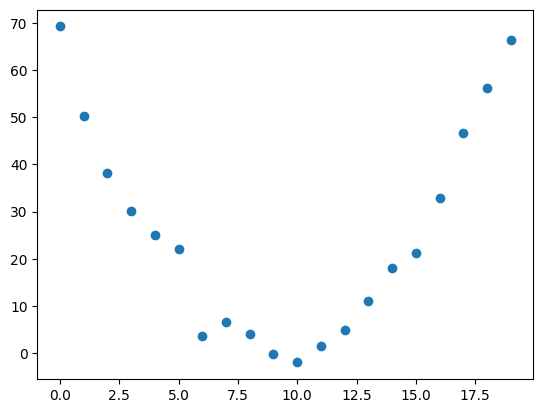

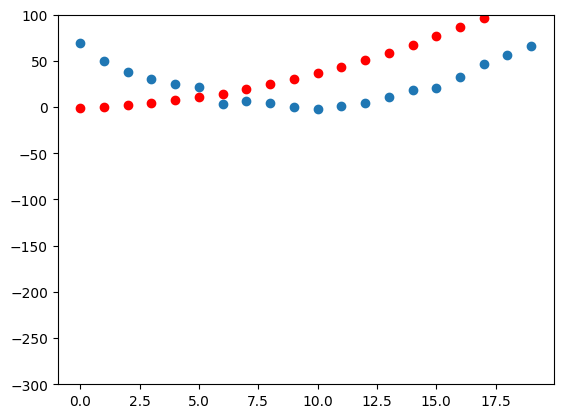

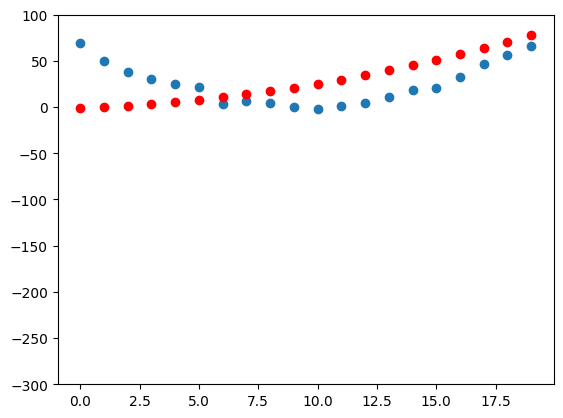

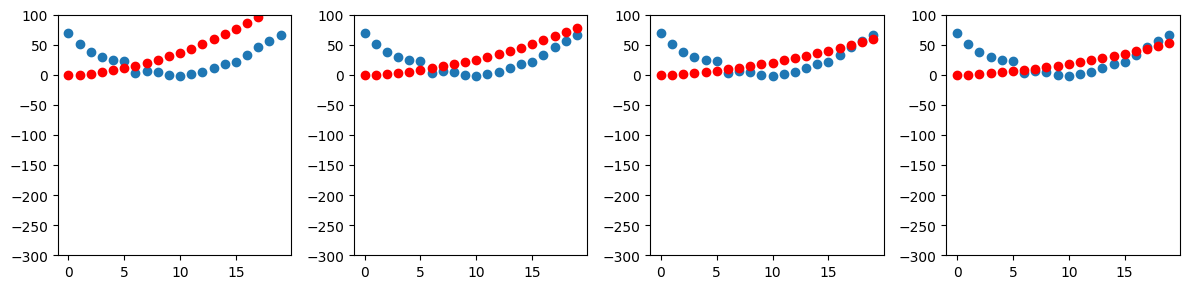

In [19]:
# Roller Coaster Problem with Stochastic Gradient Descent
# generate data
time = torch.arange(0,20).float()
speed = torch.randn(20) * 3 + 0.75 * (time - 9.5)**2 + 1
plt.scatter(time,speed)

# use SGD to find a function that fits the data for the rollercoaster data
# t - the time when we are measuring the rollercoaster speed
# params - the values that define which quadratic we're trying
def f(t, params):
    a,b,c = params
    return a * (t**2) + (b * t) + c

# Define a loss function - returns a value based on a prediction and a target
# where lower values of the functions correspond to better predictions. Need
#  loss function to return lower values when predictions are more accurate, as
#  SGD is trying to minimize this loss. For continuous data, Mean Square Error is
#  frequently used
def mse(preds, targets):
  return ((preds-targets)**2).mean()

# SGD Process
# function for visualizing how close our predictions are to targets
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

# 1. initialize weights
params = torch.randn(3).requires_grad_()
print(f"The parameter values after initialization: {params}")
orig_params = params.clone()
print(f"The original parameters: {orig_params}")

# 2. Calculate Predictions
preds = f(time, params)
show_preds(preds)

# 3. Based on the predictions, calculate how good the model is (its loss)
loss = mse(preds, speed)
print(f"Loss value: {loss}")

# 4. Calculate the gradient which measures for each weight, how changing that weight would change the loss
loss.backward()
print(f"Gradient values for each argument: {params.grad}")
# Calculate approximation of how parameters need to change
print(f"Test a new gradient with a learning rate of 1e^-5: {params.grad * 1e-5}")
print(f"Parameter values after computing the gradient: {params}")

# 5. Step (change) all the weights based on Step 4
learning_rate = 1e-5
params.data -= learning_rate * params.grad.data
params.grad = None
# Check if loss has improved
preds = f(time, params)
mse(preds, speed)
show_preds(preds)

# 6. Go back to Step 2 and repeat the process
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= learning_rate * params.grad.data
    params.grad = None
    if prn:
      print(f"Loss Value: {loss.item()}")
    return preds

for i in range(10):
  apply_step(params)
params = orig_params.detach().requires_grad_()

# 7. Iterate until you decide to stop the training process until you decide the model is good enough for your problem
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## Building the MNIST Image Classifier

### Training Dataset

In [20]:
# Build Training Dataset
# -1 view function -> make this axis as big as necessary to fit all the data
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

print(f"train_x data shape: {train_x.shape}")
print(f"train_x data tensor rank: {len(train_x.shape)}")
print(f"train_y data shape: {train_y.shape}")
print(f"train_y data tensor rank: {len(train_y.shape)}")

train_x data shape: torch.Size([12396, 784])
train_x data tensor rank: 2
train_y data shape: torch.Size([12396, 1])
train_y data tensor rank: 2


### Validation Dataset

In [21]:
# Build Validation Dataset
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
print(f"valid_x data shape: {valid_x.shape}")
print(f"valid_x data tensor rank: {len(valid_x.shape)}")
print(f"valid_y data shape: {valid_y.shape}")
print(f"valid_y data tensor rank: {len(valid_y.shape)}")

valid_x data shape: torch.Size([2038, 784])
valid_x data tensor rank: 2
valid_y data shape: torch.Size([2038, 1])
valid_y data tensor rank: 2


In [22]:
# Build a Dataset object(training data) for PyTorch
# Dataset is required to return a tuple of (x, y) when indexed
dset = list(zip(train_x,train_y))
x,y = dset[0]
print(f"datset x shape: {x.shape}")
print(f"dataset x tensor rank: {len(x.shape)}")
print(f"datset y shape: {y.shape}")
print(f"dataset y tensor rank: {len(y.shape)}")

datset x shape: torch.Size([784])
dataset x tensor rank: 1
datset y shape: torch.Size([1])
dataset y tensor rank: 1


In [23]:
# Build a Dataset object(validation data) for PyTorch
# Dataset is required to return a tuple of (x, y) when indexed
valid_dset = list(zip(valid_x,valid_y))

### Initialize Model Weights

In [24]:
# Initialize model weights
def init_params(size, std=1.0):
  return (torch.randn(size)*std).requires_grad_()

weights = init_params((28 * 28,1))

# Initialize a Bias Value
# need a bias to ensure its not 0 when the pixels are 0
bias = init_params(1)

In [25]:
# Calculate a prediction for one image
print(f"Prediction for a single image from training data: {(train_x[0]*weights.T).sum() + bias}")

Prediction for a single image from training data: tensor([-4.6132], grad_fn=<AddBackward0>)


### Linear Classifier

In [26]:
# Matrix Multiplication
#  Create a linear combination for the prediction values
# compute predictions for all the images in the training data
def linear1(xb):
  return xb@weights + bias
preds = linear1(train_x)
print(f"Predictions")
print(preds)
print(f"Prediction shape: {preds.shape}")
print(f"Prediction tensor rank: {len(preds.shape)}")

Predictions
tensor([[-4.6132],
        [-8.5214],
        [-6.7243],
        ...,
        [-6.6400],
        [ 3.2664],
        [-6.1007]], grad_fn=<AddBackward0>)
Prediction shape: torch.Size([12396, 1])
Prediction tensor rank: 2


In [27]:
# Check accuracy of prediction
corrects = (preds>0.0).float() == train_y
print(f"Accuracy of Predictions: {corrects}")
print(f"Average accuracy of all predictions: {corrects.float().mean().item()}")

Accuracy of Predictions: tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])
Average accuracy of all predictions: 0.36156824231147766


In [28]:
# Improve Accuracy
# test to see if we can improve accuracy with a small change
with torch.no_grad():
  weights[0] *= 1.0001
preds = linear1(train_x)
print(f"Average accuracy after updating the weights: {((preds>0.0).float() == train_y).float().mean().item()}")

# there is no change because the change in weights is so small that (y_new - y_old) is very close to 0 ie.
# the gradient is almost 0 everywhere

# need to find a loss function which when our weights result in slightly better predictions produces a slightly better loss

Average accuracy after updating the weights: 0.36156824231147766


### Loss Function

In [29]:
# Build a Loss Function
# loss function receive predictions from the model about the images
# the purpose of the loss function is to measure the difference between predicted values and true values ie the labels
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

# first attempt at a loss function
def mnist_loss(predictions, targets):
  # measures how distant each predictions is from 1 if it should be 1, how distant it is from 0 if it should be 0
  # and takes the mean of all the distances
    return torch.where(targets==1, 1-predictions, predictions).mean()

# need a scalar for the final loss -> the lower the loss value the better
# indicates accurate predictions are more confident and when inaccurate predictions are less confident
print(f"Test loss function: {mnist_loss(prds,trgts)}")

# issue with this loss function is that it assumes all predictions are between 0 and 1
# sigmoid function always outputs a number between 0 and 1
def sigmoid(x):
  return 1/(1+torch.exp(-x))

# second attempt at a loss function using sigmoid
def mnist_loss_sigmoid(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

print(f"Test loss function with sigmoid: {mnist_loss_sigmoid(prds,trgts)}")


Test loss function: 0.43333330750465393
Test loss function with sigmoid: 0.44596806168556213


### SGD + Mini Batches

In [30]:
# SGD + Mini Batches
# Optimization Step - updating the weights based on gradients
# need to calculate loss over one or more data items
# Solution: Calculate the average loss for a data items at a time (mini-batch)
# Batch Size - number of items in mini batch

# use fastai to build a dataloader object to shuffle data
# randomly shuffle data on every epoch before creating mini batches
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
print(f"Example of randomly generated mini-batch of batch size 5: {list(dl)}")

Example of randomly generated mini-batch of batch size 5: [tensor([12,  0,  7,  6,  9]), tensor([ 2, 13,  3, 14, 11]), tensor([ 4,  5,  1,  8, 10])]


### MNIST Model Training Loop using SGD

In [31]:
# Build a training loop for a model
# Initialize weights and bias randomly
weights = init_params((28*28,1))
bias = init_params(1)

# Create DataLoader for the training data
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
print(f"xb shape: {xb.shape}")
print(f"xb tensor rank: {len(xb.shape)}")
print(f"yb shape: {yb.shape}")
print(f"yb tensor rank: {len(yb.shape)}")

# Create DataLoader for the validation data
valid_dl = DataLoader(valid_dset, batch_size=256)

# Create a Mini-Batch of batch size 4 for testing
batch = train_x[:4]
print(f"batch shape: {batch.shape}")
print(f"batch tensor rank: {len(batch.shape)}")

# Create Predictions
# preds = linear1(batch)
# print(f"predictions: {preds}")

# Measure loss
# loss = mnist_loss_sigmoid(preds, train_y[:4])
# print(f"Loss: {loss}")

# Compute Gradients
# loss.backward()
# print(f"weights gradient shape: {weights.grad.shape}")
# print(f"Average of weight gradients: {weights.grad.mean()}")
# print(f"bias gradient: {bias.grad}")

# function for calculating gradient
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

print(f"Test calculating gradients: {calc_grad(batch, train_y[:4], linear1)}")
print(f"Average of weight gradients: {weights.grad.mean()}")
print(f"bias gradient: {bias.grad}")

# loss.backward adds the gradients of loss to any gradients that are currently stored
# so have to set the current gradients to 0 first

# training loop for an epoch
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

# check accuracy at this point
# print(f"Check Accuracy at this point: {(preds>0.0).float() == train_y[:4]}")

# function for calculating validation accuracy
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

print(f"Testing batch accuracy: {batch_accuracy(linear1(batch), train_y[:4])}")

# put batches together to create a validation epoch
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

print(f"Test validation epoch: {validate_epoch(linear1)}")

# train for 1 epoch and see if things improve
lr = 1.
params = weights, bias
train_epoch(linear1, lr, params)
print(f"check if accuracy has improved from earlier: {validate_epoch(linear1)}")

# train for a few epochs
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

xb shape: torch.Size([256, 784])
xb tensor rank: 2
yb shape: torch.Size([256, 1])
yb tensor rank: 2
batch shape: torch.Size([4, 784])
batch tensor rank: 2
Test calculating gradients: None
Average of weight gradients: -0.15112045407295227
bias gradient: tensor([-1.])
Testing batch accuracy: 0.25
Test validation epoch: 0.5065
check if accuracy has improved from earlier: 0.946
0.9534 0.9539 0.9534 0.9534 0.9529 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9539 0.9534 0.9534 0.9534 0.9534 

## PyTorch setup for SGD + Pytorch Optimizer

In [32]:
# Build SGD Functionality - PyTorch Optimizer

# intialize weights and biases in a single pytorch class
linear_model = nn.Linear(28 * 28,1)
w,b = linear_model.parameters()
print(f"weights shape: {w.shape}")
print(f"weight tensor rank: {len(w.shape)}")
print(f"bias shape: {b.shape}")
print(f"bias tensor rank: {len(b.shape)}")

# Pytorch Optimizer Setup
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

weights shape: torch.Size([1, 784])
weight tensor rank: 2
bias shape: torch.Size([1])
bias tensor rank: 1


In [33]:
# define training epoch function that use SGD
opt = BasicOptim(linear_model.parameters(), lr)

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

# check validation epoch
print(f"Check accuracy after adding SGD: {validate_epoch(linear_model)}")

# Update Model Training
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

print(f"Test training model: {train_model(linear_model, 20)}")

Check accuracy after adding SGD: 0.5413
0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 0.9534 Test training model: None


## Train MNIST Model using FastAI Library

In [34]:
# Modify Model Training Code with FastAI

# define model information that uses SGD
# linear_model = nn.Linear(28 * 28,1)
# opt = SGD(linear_model.parameters(), lr)
# train_model(linear_model, 20)

# Define new DataLoaders
dls = DataLoaders(dl, valid_dl)

# Define a general purpose Learner class
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss_sigmoid, metrics=batch_accuracy)

# Train Model with Learner.fit
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636952,0.503232,0.495584,00:00
1,0.440637,0.235429,0.791462,00:00
2,0.164770,0.166296,0.850834,00:00
3,0.073948,0.102109,0.915604,00:00
4,0.040399,0.075625,0.933268,00:00
5,0.027231,0.061010,0.948479,00:00
6,0.021780,0.051817,0.955839,00:00
7,0.019325,0.045666,0.962709,00:00
8,0.018058,0.041325,0.965162,00:00
9,0.017283,0.038114,0.967615,00:00


## Neural Networks

Linear classifiers are limited in what they can do. To handle more complex functions we need to add a nonlinear function between two linear classifiers. This is what defines a **neural network**.

In [35]:
# define a simple neural network

# randomly intialize weights and biases
w1 = init_params((28 * 28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

# def simple_net(xb):
#     res = xb@w1 + b1
#     # Rectified Linear Unit - RELU -> replaces every negative number with 0
#     res = res.max(tensor(0.0))
#     res = res@w2 + b2
#     return res

In [36]:
# Pytorch version of a simple neural network
simple_net = nn.Sequential(
    nn.Linear(28 * 28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [37]:
# Apply Simplenet to MNIST data
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss_sigmoid, metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.282393,0.406792,0.505888,00:00
1,0.134344,0.215805,0.817959,00:00
2,0.076003,0.111737,0.918057,00:00
3,0.051048,0.076866,0.940628,00:01
4,0.039343,0.060505,0.956330,00:00
5,0.033269,0.051137,0.962709,00:00
6,0.029718,0.045164,0.965653,00:00
7,0.027371,0.041064,0.966634,00:00
8,0.025655,0.038072,0.969087,00:00
9,0.024313,0.035779,0.970069,00:00


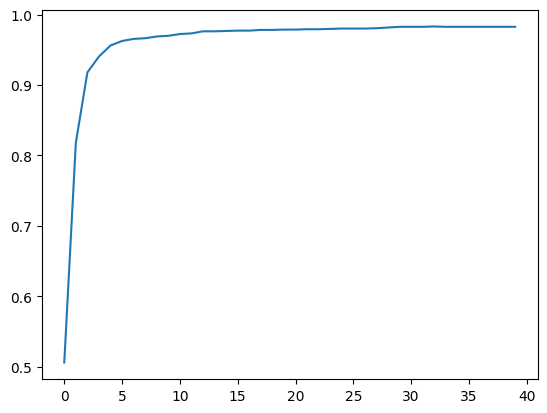

In [38]:
# visualize the accuracy of model using simplenet
# y axis - accuracy
# x-axis number of epochs
plt.plot(L(learn.recorder.values).itemgot(2));

In [39]:
print(f"Final Accuracy of model on the MNIST dataset: {learn.recorder.values[-1][2]}")

Final Accuracy of model on the MNIST dataset: 0.982826292514801


## Going Deeper into Deep Learning + Neural Networks

The following code below is an 18 layer resnet model with nearly 100% accuracy on the MNIST data. The above code was a simple neural network with 2 layers so the results of resnet-18 on this data show that accuracy improves as we add more layers. One thing to consider are the trade off's mentioned by Jeremy in the lecture video

In [40]:
# Going Deeper into Deep Learning + Neural Networks
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.089190,0.011672,0.998037,00:18


## Terminology

**Activations(Neural Network)** - Numbers that are calculated (both by linear and non-linear layers)

**Parameters(Neural Network)** - Numbers that are randomly initialized, and optimized (that is, the numbers that define the model)

**Axis(Numpy), Dimensions(PyTorch Tensors)** - For a matrix, the rows and columns define the axis

**Tensor Rank** - The number of dimensions in a tensor

**Rank Zero Tensor** - Scalar

**Rank One Tensor** - Vector

**Rank Two Tensor** - Matrix

**Nonlinearity (Activation Function)** - one type of layer in a neural network. Typically a neural network alternates between a linear layer and non-linear layer. Occasionally people refer to a single layer = linear layer + nonlinearity

**Relu** - Function that returns 0 for negative numbers and doesn't change positive numbers

**Mini-Batch** - A small group of inputs and labels gathered together in two arrays. A gradient desccent step is updated on this batch rather than a whole epoch

**Forward Pass** - Applying the model to some input and computing the predictions

**Loss** - A value that represents how well (or bad) the model is doing
**Gradient** - The derivative(slope) of the loss with respect to some parameter of the model

**Backward Pass** - Computing the gradients of the loss with respect to all model parameters

**Gradient Descent** - Taking a step in the directions opposite to the gradients to make the model parameters a little bit better

**Learning Rate** - The size of the step we take when applying SGD to update the parameters of the model. Usually a very tiny model

## Resources

1. [FastAI Lesson 3](https://www.youtube.com/watch?v=hBBOjCiFcuo)
2. [FastAI Chapter 4, MNIST Basics](https://colab.research.google.com/github/fastai/fastbook/blob/master/04_mnist_basics.ipynb#scrollTo=0rEdjkeOSJbJ)
3. [How Does a Neural Net Really Work](https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work)
4. [Which Image Models are Best ](https://www.kaggle.com/code/jhoward/which-image-models-are-best/)
5. [3Blue1Brown Neural Networks](https://youtu.be/aircAruvnKk?feature=shared)
6. [Andrej Karpathy Neural Networks Zero to Hero](https://karpathy.ai/zero-to-hero.html)
7. [Understanding Dimensions in PyTorch](https://towardsdatascience.com/understanding-dimensions-in-pytorch-6edf9972d3be)
8. [Understanding Numpy Axis](https://medium.com/intuitionmath/numpy-sum-axis-intuition-6eb94926a5d1)
9. [Pytorch Documentation](https://pytorch.org/docs/stable/index.html)
10. [fastai Documentation](https://docs.fast.ai/)